# Introduction to Vision Transformers - Mini Project
---
<div style="font-size: 20px">
  Group:
  <br>
  Homework H 
  <br>
  Created by: Muazzam Bin Aqeel---(Matrikel-Nr. 3139776) & Wesley dos santos Barisch---(Matrikel-Nr. 3140227)</div>



## Task 2: Visualizing attention in ViTs

Attention in ViTs tells us which parts of an image are important for some other image parts (or for the classification itself). This provides a form of inherent explainability. In this task, you should explore this option and visualize attention maps to understand, what a ViT is looking at in the image. As a starting point, **read this excellent [blog post](https://jacobgil.github.io/deeplearning/vision-transformer-explainability) by Jacob Gildenblat** to get an understanding of how attention can be visualized in ViTs. Here are some more **implementations** that might help you with the task:

* https://github.com/mashaan14/VisionTransformer-MNIST/blob/main/VisionTransformer_MNIST.ipynb
* https://github.com/jacobgil/vit-explain/tree/main
* https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb



### Task 2.1: Modify our ViT implementation to output the attention matrix 
<span style="color:blue">
    To visualize attention for a specific image, the model needs to output not only its prediction, but also the attention matrix. You should adapt the <code>VisionTransformer</code> class that we used in the material notebook in such a way that it outputs the attention matrix <code>x_attention</code>.
</span>



### Task 2.2: Write a function that creates an attention heatmap for a specific image
To visualize the attention values as an image, the matrix must first be transformed. Remember, the attention matrix is of shape `[layers, attention_heads, num_patches+class_token, num_patches+class_token]`, but we want to view it as a grayscale image of size 28x28. Therefore, the function needs the following components:

* <span style="color:blue">Aggregate the attention weights across all heads. Just like in the <a href="https://jacobgil.github.io/deeplearning/vision-transformer-explainability">blog post</a> by Jacob Gildenblat you should implement a <code>mean</code>, <code>min</code>, and <code>max</code> aggregation! </span>
* <span style="color:blue">Again leaning on the idea by <a href="https://jacobgil.github.io/deeplearning/vision-transformer-explainability">Jacob Gildenblat</a>, you should implement a filter to discard attention values below a certain threshold. You can implement this as a function parameter <code>discard_ratio</code>.  </span>
* <span style="color:blue">The function should be able to <b>select specific layers</b>. With that we can later see, how different network depths behave.</span>
* <span style="color:blue">The function needs to account for <b>residual connections</b> by adding an identity matrix and then re-normlize the weights.</span>
* <span style="color:blue">Since we are not interested in the absolut attention values as much as the flow and change of attention weights through the network, you need to <b>recursively multiply the attention weight matrices</b> from successive layers to trace how attention flows from the input to the output.</span>
* <span style="color:blue">Finally, you need to reshape the resulting <code>joint_attentions</code> to match the image size.</span>


### Task 2.3: Use the function to visualize attention maps for example images
Now you should finally put everything together and visualize some attention maps to understand, what the model is looking at in the images! 

* <span style="color:blue">Load the weights of the best model from the material notebook <code>ViT_model.pt</code> into your adapted <code>VisionTransformer</code></span>
* <span style="color:blue">Visualize multiple original images as well as their attention maps in a grid. </span>
* <span style="color:blue">Try different <b>aggregation methods</b> for attention heads, <b>discard ratios</b> and <b>layers</b>.  </span>
* <span style="color:blue">Interpret your findings!</span>


## Imports

In [2]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
import os
import torch.nn as nn
from torch import optim
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

In [3]:
print(torch.__version__)
#check if cuda is available
cuda_available = torch.cuda.is_available()
print(f"cuda available: {cuda_available}")
if cuda_available:
    print(f"GPU: {torch.cuda.get_device_name(0)}")

USE_ONLY_CPU = False
if USE_ONLY_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if cuda_available else "cpu")
print(f'Using {device}')

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.1.0+cu118
cuda available: True
GPU: NVIDIA GeForce RTX 3090
Using cuda


In [4]:
# Training parameters
EPOCHS = 10
WARMUP_EPOCHS = 10
BATCH_SIZE = 128
N_CLASSES = 10
N_WORKERS = 0
LR = 5e-4

# Data parameters
DATASET = 'fmnist'
IMAGE_SIZE = 28
PATCH_SIZE = 4
N_CHANNELS = 1
DATA_PATH = './data/'

# ViT parameters
EMBED_DIM = 64
N_ATTENTION_HEADS = 4
FORWARD_MUL = 2
N_LAYERS = 6
DROPOUT = 0.1
MODEL_PATH = './models'
LOAD_MODEL = False

In [5]:
train_transform = transforms.Compose([transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
                              transforms.RandomCrop(IMAGE_SIZE, padding=2), 
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5])])
train = datasets.FashionMNIST(os.path.join(DATA_PATH, DATASET), train=True, download=True, transform=train_transform)

test_transform = transforms.Compose([transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
test = datasets.FashionMNIST(os.path.join(DATA_PATH, DATASET), train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             num_workers=N_WORKERS,
                                             drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=N_WORKERS,
                                            drop_last=False)

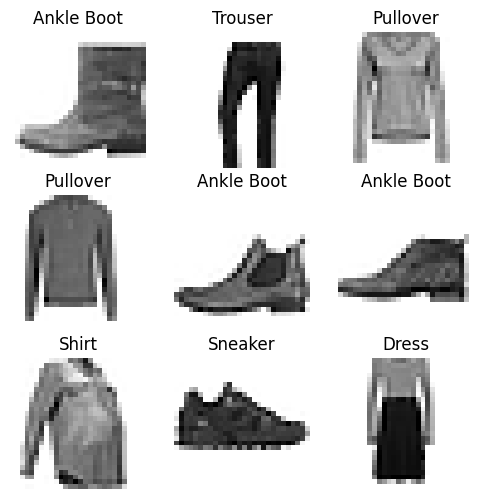

In [6]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (6,6))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train), size = (1,)).item()
    image, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray_r')
plt.show()

In [7]:
# Get a single example image without transformations
vis_loader = torch.utils.data.DataLoader(dataset=train,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=N_WORKERS,
                                         drop_last=True)

images, _ = next(iter(vis_loader))

In [8]:
conv_layer = nn.Conv2d(in_channels = N_CHANNELS, out_channels = EMBED_DIM, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

In [9]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(images)
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

Shape of embeddings through the conv layer -> [1, 64, 7, 7] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 49, 64] <- [batch_size, num_of_patches, embedding_dims]


In [10]:
class EmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size, dropout=0.0):
        super().__init__()
        # Convolutional layer to convert image patches to embeddings
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding

        # Classification token, learnable parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        
        # Positional embeddings for each patch + 1 for the classification token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Convert image to patch embeddings
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)

        # Flatten the patch embeddings
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)

        # Transpose to match transformer input shape
        x = x.transpose(1, 2)  # B E S -> B S E 

        # Add classification token at the start of each sequence
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        
        # Add positional embeddings
        x = x + self.pos_embedding  # Adding positional embedding
        
        # Apply dropout
        x = self.dropout(x)
        return x

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_attention_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_attention_heads = n_attention_heads
        self.head_embed_dim = embed_dim // n_attention_heads

        # Linear layers for query, key, and value projections
        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads) # Queries projection
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)    # Keys projection
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)  # Values projection

        # Output projection layer
        self.out_projection = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        b, s, e = x.shape

        # Project inputs to queries, keys, and values
        xq = self.queries(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        xq = xq.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        xk = self.keys(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        xk = xk.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        xv = self.values(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        xv = xv.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        # Compute Attention presoftmax values
        xk = xk.transpose(-1, -2)  # B, H, K, HE -> B, H, HE, K
        x_attention = torch.matmul(xq, xk)  # B, H, Q, HE  *  B, H, HE, K -> B, H, Q, K

        # Scale presoftmax values for stability
        x_attention /= float(self.head_embed_dim) ** 0.5

        # Compute Attention Matrix
        x_attention = torch.softmax(x_attention, dim=-1)

        # Compute Attention Values
        x = torch.matmul(x_attention, xv)  # B, H, Q, K * B, H, V, HE -> B, H, Q, HE

        # Format the output
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(b, s, e)  # B, Q, H, HE -> B, Q, E
        x = self.out_projection(x)  # B, Q, E -> B, Q, E
        return x, x_attention

What follows is a very straightforward implementation of the transformer encoder, using our `SelfAttention` class from above, together with the **layer normalization** `nn.LayerNorm`, **dropout** `nn.Dropout`, and **MLP layers** `nn.Linear`:

In [12]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, n_attention_heads, forward_mul, dropout=0.0):
        super().__init__()
        # Layer normalization and self-attention layer
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, n_attention_heads)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward network layers
        self.norm2 = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Apply self-attention with skip connection
        t, s = self.attention(self.norm1(x))
        x = x + self.dropout1(t)

        # Apply feed-forward network with skip connection
        x = x + self.dropout2(self.fc2(self.activation(self.fc1(self.norm2(x)))))
        return x, s

#### Component 3: Classifier

The classifier is composed of two hidden layers of a Multi-Layer Perceptron (MLP) `nn.Linear` with a tanh `nn.Tanh` activation function in-between the hidden layers. The final output of this classification head is the prediction for the image classification task. By using a *class token*, the model can directly map the summarized information to the desired output classes.

In [13]:
class Classifier(nn.Module):
    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # Linear layers for classification
        # New architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        # Use only the classification token for prediction
        x = x[:, 0, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

#### Combining everything to a ViT

We can now combine all these components to create the final ViT model:

In [14]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes, dropout=0.1):
        super().__init__()
        # Embedding layer
        self.embedding = EmbedLayer(n_channels, embed_dim, image_size, patch_size, dropout=dropout)

        # Encoder layers
        self.encoder = nn.ModuleList([Encoder(embed_dim, n_attention_heads, forward_mul, dropout=dropout) for _ in range(n_layers)])
        
        # Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier
        self.classifier = Classifier(embed_dim, n_classes)

        # Initialize weights
        self.apply(vit_init_weights)

    def forward(self, x, return_attention=False):
        # Apply embedding and encoder layers
        x = self.embedding(x)
        i = 0
        for block in self.encoder:
            x, s = block(x)
            if i == 0:
                attention_list = s
            else:
                torch.cat((attention_list, s), dim=0)
            i += 1
                
        x = self.norm(x)
        x = self.classifier(x)
        if return_attention:
            return x, attention_list
        return x

Model weights are initialized as follows:

In [15]:
def vit_init_weights(m): 
    # Initialize weights for Conv2d and Linear layers
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    # Initialize weights for LayerNorm
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Initialize weights for EmbedLayer
    elif isinstance(m, EmbedLayer):
        nn.init.trunc_normal_(m.cls_token, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.pos_embedding, mean=0.0, std=0.02)

We can now initialize the model:

In [16]:
# Initialize model
model = VisionTransformer(n_channels=N_CHANNELS, embed_dim=EMBED_DIM, 
                          n_layers=N_LAYERS, n_attention_heads=N_ATTENTION_HEADS, 
                          forward_mul=FORWARD_MUL, image_size=IMAGE_SIZE, 
                          patch_size=PATCH_SIZE, n_classes=N_CLASSES, dropout=DROPOUT)

In [17]:
# Load model parameters to cuda
model = model.to(device)

In [18]:
# Show model architecture
model

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_af

In [19]:
# Show number of model parameters
params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} learnable parameters")   

Model has 210,122 learnable parameters


### Training

(original implementation in `solver.py`)

To following code to train the model is quite similar to code we have already seen and used in other lectures. One important difference is the usage of **schedulers** `optim.lr_scheduler.LinearLR` and `optim.lr_scheduler.CosineAnnealingLR`. These schedulers adapt the learning rate dynamically during training, which helps the model converge and achieve better performance (for object detection we adapted the learning rate by hand ...).

In [20]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [21]:
def test_dataset(model,loss_fn,loader):
    # Set Vision Transformer to evaluation mode
    model.eval()

    # Arrays to record all labels and logits
    all_labels = []
    all_logits = []

    # Testing loop
    for (x, y) in loader:
        x = x.cuda()

        # Avoid capturing gradients in evaluation time for faster speed
        with torch.no_grad():
            logits = model(x)

        all_labels.append(y)
        all_logits.append(logits.cpu())

    # Convert all captured variables to torch
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)
    all_pred = all_logits.max(1)[1]
    
    # Compute loss, accuracy and confusion matrix
    loss = loss_fn(all_logits, all_labels).item()
    acc = accuracy_score(y_true=all_labels, y_pred=all_pred)
    cm = confusion_matrix(y_true=all_labels, y_pred=all_pred, labels=range(N_CLASSES))

    return acc, cm, loss

def test(model,loss_fn,train_loader,test_loader):
    # Test using test loader
    acc, cm, loss = test_dataset(model,loss_fn,test_loader)
    print(f"Test acc: {acc:.2%}\tTest loss: {loss:.4f}")
    # Optional: print confusion matrix
    #print(cm)

    return acc, loss

In [22]:
# Train
iters_per_epoch = len(train_loader)

# Define optimizer for training the model
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# scheduler for linear warmup of lr and then cosine decay
linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_EPOCHS, end_factor=1.0, total_iters=WARMUP_EPOCHS-1, last_epoch=-1)
cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)

# Variable to capture best test accuracy
best_acc = 0

train_start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    
    start_time = time.time()
    # Set model to training mode
    model.train()

    # Arrays to record epoch loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []

    # Loop on loader
    for i, (x, y) in enumerate(train_loader):

        # Push to GPU
        x, y = x.cuda(), y.cuda()

        # Get output logits from the model 
        logits = model(x)

        # Compute training loss
        loss = loss_fn(logits, y)

        # Updating the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch metrics
        batch_pred = logits.max(1)[1]
        batch_accuracy = (y==batch_pred).float().mean()
        train_epoch_loss += [loss.item()]
        train_epoch_accuracy += [batch_accuracy.item()]

        # Log training progress
        if i % 50 == 0 or i == (iters_per_epoch - 1):
            print(f'Ep: {epoch+1}/{EPOCHS}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

    end_time = time.time()

    # Print elapsed time for the epoch
    print(f"Training time for epoch {epoch} in minutes: {(end_time - start_time) / 60:.2f}")

    # Print train acc and loss
    print('------------')
    print(f"Train acc: {sum(train_epoch_accuracy)/iters_per_epoch:.2%}\tTrain loss: {sum(train_epoch_loss)/iters_per_epoch:.4f}")
    
    # Test the test set after every epoch
    test_acc, test_loss = test(model,loss_fn,train_loader,test_loader)
    
    # Capture best test accuracy
    best_acc = max(test_acc, best_acc)
    print(f"Best test acc: {best_acc:.2%}")

    # Save model if accuracy improves
    if test_acc >= best_acc:
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, "ViT_model.pt"))
        print('New model saved!\n')
    
    # Update learning rate using schedulers
    if epoch < WARMUP_EPOCHS:
        linear_warmup.step()
    else:
        cos_decay.step()

    # Update training progression metric arrays
    train_losses += [sum(train_epoch_loss)/iters_per_epoch]
    test_losses += [test_loss]
    train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
    test_accuracies += [test_acc]

train_end_time = time.time()
# overall training time
print(f"Overall training time in minutes: {(train_end_time - train_start_time) / 60:.2f} minutes on {device} for {EPOCHS} epochs")

Ep: 1/10	It: 1/468	batch_loss: 2.3056	batch_accuracy: 7.03%
Ep: 1/10	It: 51/468	batch_loss: 2.2498	batch_accuracy: 22.66%
Ep: 1/10	It: 101/468	batch_loss: 2.1745	batch_accuracy: 23.44%
Ep: 1/10	It: 151/468	batch_loss: 2.0838	batch_accuracy: 22.66%
Ep: 1/10	It: 201/468	batch_loss: 2.0024	batch_accuracy: 18.75%
Ep: 1/10	It: 251/468	batch_loss: 1.9290	batch_accuracy: 32.81%
Ep: 1/10	It: 301/468	batch_loss: 1.9089	batch_accuracy: 30.47%
Ep: 1/10	It: 351/468	batch_loss: 1.8333	batch_accuracy: 35.94%
Ep: 1/10	It: 401/468	batch_loss: 1.8103	batch_accuracy: 27.34%
Ep: 1/10	It: 451/468	batch_loss: 1.9060	batch_accuracy: 24.22%
Ep: 1/10	It: 468/468	batch_loss: 1.7949	batch_accuracy: 25.00%
Training time for epoch 0 in minutes: 0.29
------------
Train acc: 25.14%	Train loss: 2.0050
Test acc: 28.26%	Test loss: 1.8861
Best test acc: 28.26%
New model saved!

Ep: 2/10	It: 1/468	batch_loss: 1.8398	batch_accuracy: 30.47%
Ep: 2/10	It: 51/468	batch_loss: 1.8124	batch_accuracy: 22.66%
Ep: 2/10	It: 101/468

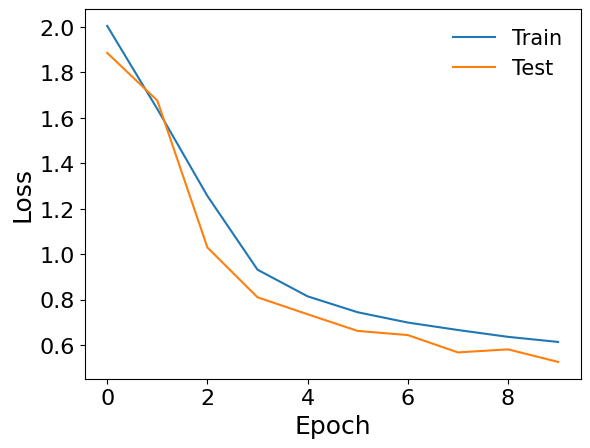

In [23]:
# Plot graph of loss values
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')

plt.ylabel('Loss', fontsize = 18)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(fontsize=16)
plt.legend(fontsize=15, frameon=False)

plt.show()

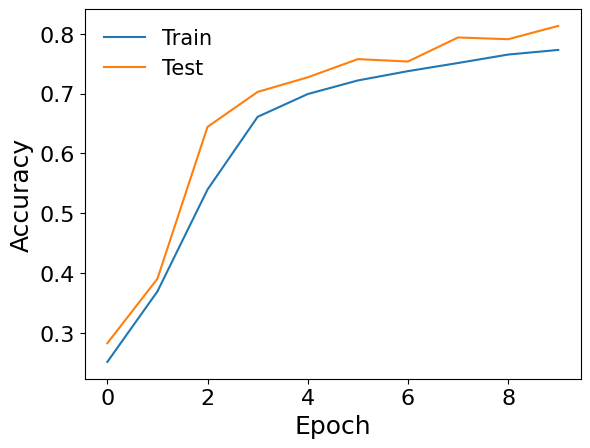

In [24]:
# Plot graph of accuracies
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')

plt.ylabel('Accuracy', fontsize = 18)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(fontsize=16)
plt.legend(fontsize=15, frameon=False)

plt.show()

In [25]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

In [26]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "ViT_model.pt")))
model.to(device)

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_af

In [27]:
offset = 42
# test on images offset to offset+16 of the first set
batch_test = next(iter(test_loader))

preds, _ = predict_batch(model, batch_test[0][offset:offset+16], binary=False)

print(f'Predictions:\t\t {preds}')
print(f'Labels (ground truth):\t {batch_test[1][offset:offset+16]}')

Predictions:		 tensor([4, 9, 6, 9, 6, 3, 4, 2, 6, 2, 5, 6, 4, 2, 8, 4])
Labels (ground truth):	 tensor([3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4])


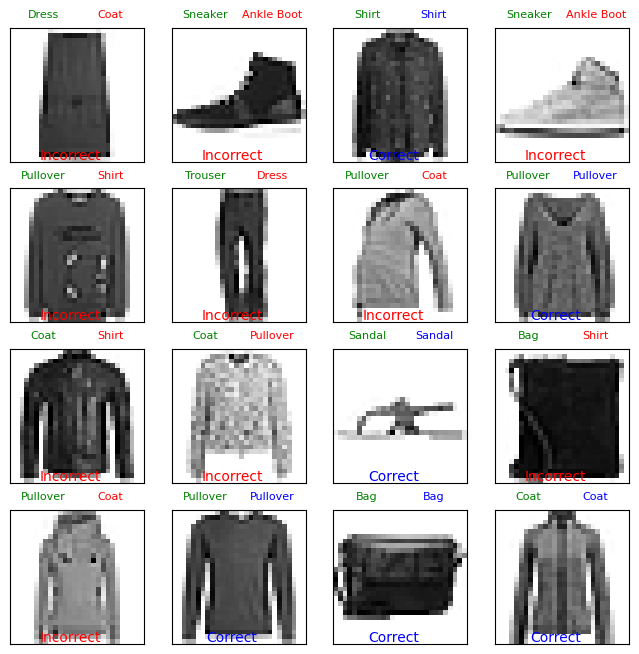

In [28]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        pred = preds[i]
        label = batch_test[1][offset+i]
        pred_txt = labels_map[int(pred)]
        label_txt = labels_map[int(label)]
        
        correct = pred == label
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][offset+i].view(28, 28)
        ax.imshow(img, cmap='gray_r');
        ax.text(0.25, 1.1, '{}'.format(label_txt), 
                size=8, color='green',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.75, 1.1, '{}'.format(pred_txt), 
                size=8, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.45, 0.05, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=10, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

In [29]:
def rollout(attentions, discard_ratio, head_fusion, layer):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=0)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=0)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=0)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            print(I.shape)
            print(attention_heads_fused.shape)
            I = I.to(device)
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = result.to(device)
            result = torch.matmul(a, result)

    # result = result[layer]
    print(result.shape)
    attn_heatmap = result[0, 1:].reshape((int(IMAGE_SIZE/PATCH_SIZE), int(IMAGE_SIZE/PATCH_SIZE)))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [IMAGE_SIZE, IMAGE_SIZE], mode='bilinear').view(28, 28, 1)
    return attn_heatmap_resized


In [30]:
def attention_matrix_show(model, datapoint, aggregate, discard_ratio, layer):
    datapoint = datapoint.to(device)
    output, x_attention = model(datapoint, return_attention=True)

    fig, aa = plt.subplots(1, layer + 1, figsize=(15, 5))


    aa[0].imshow(datapoint[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    aa[0].axis('off')

    for layer in range(layer):
        heatmap = rollout(x_attention, discard_ratio=discard_ratio, head_fusion=aggregate, layer=layer)
        aa[layer + 1].imshow(heatmap.cpu().numpy(), cmap='viridis')
        aa[layer + 1].set_title(f'{layer}')
        aa[layer + 1].axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50, 50])


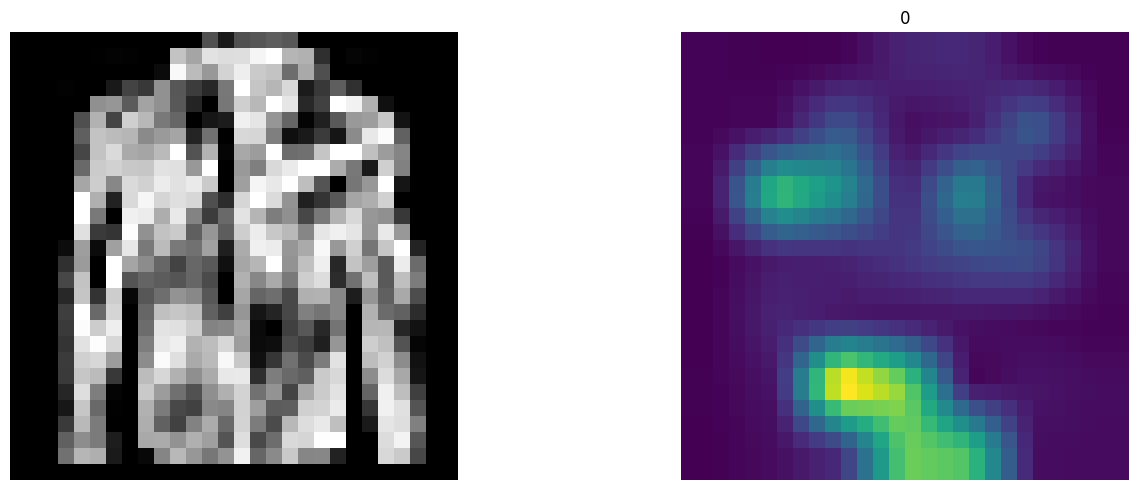

In [31]:
batch_test = next(iter(test_loader))
datapoint = batch_test[0][17:18]
attention_matrix_show(model, datapoint, "min", 0.0, 1)

With the "min" aggregation, we can identify a focus on the mid lower side of the image for identification.

torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50, 50])


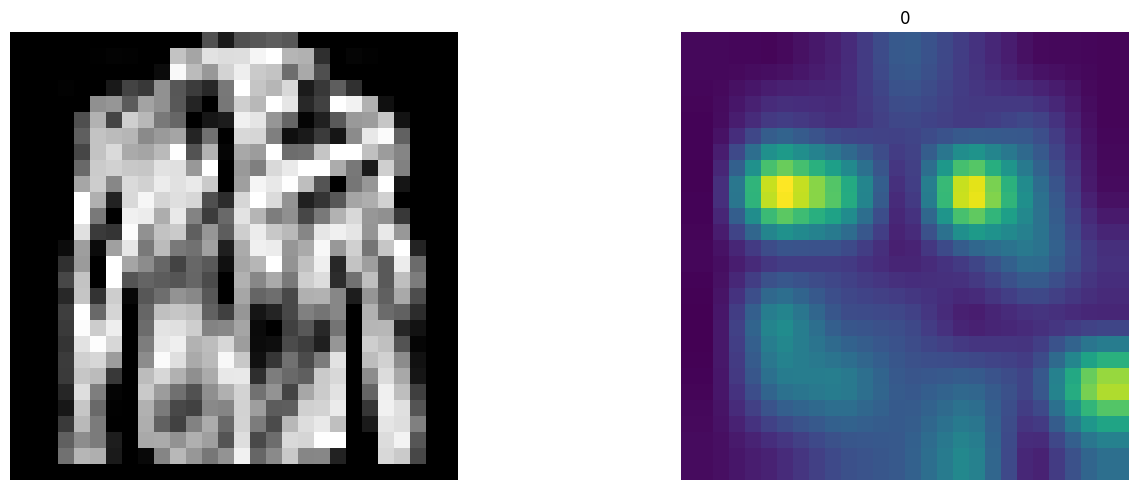

In [34]:
attention_matrix_show(model, datapoint, "mean", 0.0, 1)

Now with the "mean" aggregation, we see a shift on the identification focus to 3 points which are very different from the "min" aggregation.

torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50, 50])


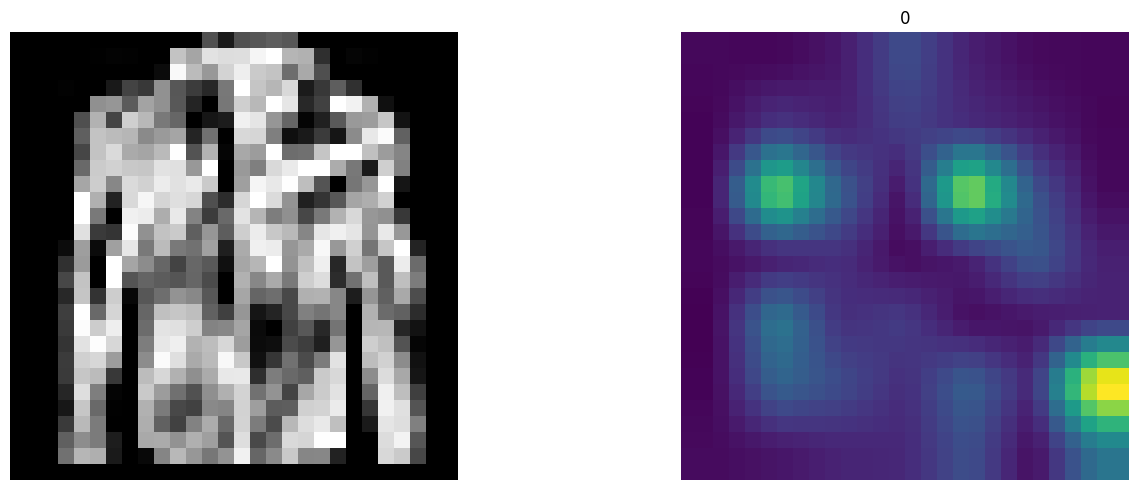

In [35]:
attention_matrix_show(model, datapoint, "max", 0.0, 1)

The "max" aggregation is similar to the "mean", but shifts some of the focus from the 2 middle points to the lower right one for indentification.

## Task 3: Using the inductive bias of CNNs to support the training of ViTs
As task 1 has shown, the lack of an inductive bias can be a blessing and a curse. While such models excel on huge datasets, it is especially problematic on smaller datasets. In this task you should combine the a CNN and ViT technology to create *the best of two worlds*.

In the 2021 paper [Training data-efficient image transformers & distillation through attention](https://arxiv.org/pdf/2012.12877), Meta AI did exactly that: combining CNN and ViT to achieve a very high performing model with good convergence properties. This was done by using [knowledge distillation](https://en.wikipedia.org/wiki/Knowledge_distillation). A CNN model was trained first and used as a teacher for a ViT student model. With the teachers guidance, the ViT student achieves better performance with shorter training times. **This is exactly what you should be doing in this task!** It is therefore strongly advised that you read the [original paper](https://arxiv.org/pdf/2012.12877). The [paper on knowledge distillation](https://arxiv.org/pdf/1503.02531) by Geoffrey Hinton, Oriol Vinyals, and Jeff Dean could also help to understand this technology!

Here are some more **implementations** that might help you with the task:

* [DeiT implementation of Francesco Saverio](https://github.com/FrancescoSaverioZuppichini/DeiT)
* [DeiT implementation of Shuqi Huang](https://github.com/jiaowoguanren0615/Deit-Pytorch/blob/main/DeiT/models/deitv1.py)
* [Official DeiT implementation by Meta](https://github.com/facebookresearch/deit/blob/main/models_v2.py)

### Task 3.1: Training a teacher model
To distill knowledge from a strong teacher model, you first need to train such a model!

* <span style="color:blue">Set up a standard CNN model in PyTorch to train on the fashion mnist dataset.</span>
* <span style="color:blue">You can use the CNN from the introduction to CNN models. It should already have the correct layer formats, since we originally used it on the mnist dataset.</span>
* <span style="color:blue">Use any training loop to train and evaluate the CNN model. How does it compare to the ViT from the material notebook? <i>Hint: it needs to be better to actually work as a teacher model!</i> </span>
* <span style="color:blue">Save the model weights for later use in <code>teacher_model.pt</code></span>
* <span style="color:blue">Interpret your findings!</span>

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define the CNN architecture for the teacher model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and the optimizer
teacher_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

# Define transformations for the training data and testing data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Training the model
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# Create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model weights in the models directory
teacher_model_path = os.path.join('models', 'teacher_model.pt')
torch.save(teacher_model.state_dict(), teacher_model_path)

print(f"Model training complete and weights saved to {teacher_model_path}")


Epoch 1, Loss: 0.4766434431393772
Epoch 2, Loss: 0.3025954280421932
Epoch 3, Loss: 0.2543912494837094
Epoch 4, Loss: 0.22196558335108924
Epoch 5, Loss: 0.19814525817090006
Epoch 6, Loss: 0.17500961571534687
Epoch 7, Loss: 0.15867474422589548
Epoch 8, Loss: 0.14096466681636027
Epoch 9, Loss: 0.1272911136852764
Epoch 10, Loss: 0.11545514917747775
Model training complete and weights saved to models/teacher_model.pt


<b>Evaluation:</b> 
<br>
In Epoch 1, the initial loss starts at 0.4766, which is normal since the model begins with random settings. By the middle of the training, the loss drops to 0.1981, showing that the model is learning well. By the end of the training, the loss decreases further to 0.1155, indicating the model is improving a lot. This steady decrease in loss means the model is understanding the data without overfitting, as the loss keeps going down smoothly without any sudden increases or leveling off.

### Task 3.2: Distillation loss
To use knowledge distillation you need to use a new loss function. This function should combine the student and teacher loss.

* <span style="color:blue">Implement a <code>HardDistillationLoss</code> function, which combines the student and teacher loss and weighs them with 0.5 each.</span>
* <span style="color:blue">The function should use "hard" labels (see the <a href="https://arxiv.org/pdf/2012.12877">paper</a> for hints).</span>
* <span style="color:blue">Use <code>CrossEntropyLoss</code>.</span>

In [45]:
class HardDistillationLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(HardDistillationLoss, self).__init__()
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_outputs, teacher_outputs, labels):
        # Hard labels from the teacher
        _, hard_labels = torch.max(teacher_outputs, dim=1)
        
        student_loss = self.criterion(student_outputs, labels)
        teacher_loss = self.criterion(student_outputs, hard_labels)
        
        loss = self.alpha * student_loss + (1 - self.alpha) * teacher_loss
        return loss


### Task 3.3: Changing the ViT architecture to allow distillation
The distillation procedure in the [paper](https://arxiv.org/pdf/2012.12877) works by introducing a distillation token, which plays the same role as the class token, except that it aims at reproducing the label estimated by the teacher. Both tokens interact in the transformer through attention. In this task you should change the ViT architecture to integrate this token!


* <span style="color:blue">Add a distillation token to the <code>EmbedLayer</code>. This works the same way as the classification token. You can also initialize it as a <code>nn.Parameter</code> with <code>torch.zeros</code>. </span>
* <span style="color:blue">Think about what needs to be changed for the <code>pos_embedding</code>!</span>
* <span style="color:blue">Change the <code>Classifier</code> class to use the classification token <i>and</i> distillation token for prediction. <b>Add a linear layer</b> to project the distillation token (you dont need 2 layers and activation function here, just the linear layer is enough). During training, the <code>Classifier</code> should output the classification <b>and</b> the distillation projection, which will be used by the loss function from task 3.2. During inference, both outputs should be averaged. </span>
* <span style="color:blue">Name your new model <code>MyDeiT</code>. </span>

In [46]:
class MyDeiT(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super(MyDeiT, self).__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # Add class token and distillation token
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.distill_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        self.patch_embeddings = nn.Conv2d(1, embed_dim, kernel_size=16, stride=16)  # Adjusted to 1 channel input
        self.position_embeddings = nn.Parameter(torch.zeros(1, 2 + 1, embed_dim))  # Adjust size for patches and tokens
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=12, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=12)
        
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.distill_classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Patch embedding
        x = self.patch_embeddings(x)  # (B, E, H, W)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        
        # Concatenate class token and distillation token
        cls_tokens = self.class_token.expand(batch_size, -1, -1)
        distill_tokens = self.distill_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, distill_tokens, x), dim=1)  # (B, 2 + N, E)
        
        x = x + self.position_embeddings
        x = self.transformer_encoder(x)
        
        # Separate the class token and distillation token
        cls_output = x[:, 0]
        distill_output = x[:, 1]
        
        # Classifier output
        cls_logits = self.classifier(cls_output)
        distill_logits = self.distill_classifier(distill_output)
        
        return cls_logits, distill_logits


### Task 3.4: Train your own DeiT model

* <span style="color:blue">Initialize a student model based on your new <code>MyDeiT</code> class. Use the same parameter configuration as before. </span>
* <span style="color:blue">Train the student model with the <code>HardDistillationLoss</code> you built in task 3.2!</span>
* <span style="color:blue">Your training loop might need to account for the second output (the distillation token) when making batch predictions during <code>train()</code> mode. </span>
* <span style="color:blue">Interpret your results!</span>

In [50]:
import torch.optim as optim

# Initialize student model
student_model = MyDeiT(embed_dim=768, num_classes=10) 

# Loss function
criterion = HardDistillationLoss(alpha=0.5)

# Optimizer
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# Training loop for the student model
num_epochs = 10  
student_model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        # Forward pass
        student_cls_logits, student_distill_logits = student_model(images)
        with torch.no_grad():
            teacher_outputs = teacher_model(images)
        
        # Compute loss
        loss = criterion(student_cls_logits, teacher_outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader)}")

# Save the trained student model
student_model_path = os.path.join('models', 'student_model.pth')
torch.save(student_model.state_dict(), student_model_path)

print(f"Student model training complete and weights saved to {student_model_path}")


Epoch [1/10], Loss: 0.7091232739023562
Epoch [2/10], Loss: 0.5746284640991866
Epoch [3/10], Loss: 0.5240462121011605
Epoch [4/10], Loss: 0.4949278378569241
Epoch [5/10], Loss: 0.4614460648122881
Epoch [6/10], Loss: 0.4437265270459118
Epoch [7/10], Loss: 0.419847833242879
Epoch [8/10], Loss: 0.3956022120233792
Epoch [9/10], Loss: 0.3838225802077032
Epoch [10/10], Loss: 0.3663586629574487
Student model training complete and weights saved to models/student_model.pth


<b>Evaluation</b>
<br>

The student model's training shows improvement but not as much as the teacher model in Task 3.1. Initially, the student model starts with a higher loss of 0.7091 compared to the teacher's 0.4766. By the fifth epoch, the student's loss drops to 0.4614, indicating it is learning well, but still not as effectively as the teacher. By the tenth epoch, the student model's loss is 0.3664, higher than the teacher model's 0.1155 

**Why the Results are Different from Task 3.1:**
The teacher model in Task 3.1 is more complex and has more parameters, which helps it learn better from the data. The student model in Task 3.4 is simpler and has fewer parameters, so it can't capture as much detail from the data. Although the student model learns from the teacher model, its simpler structure leads to higher final loss values, showing it isn't as proficient.